In [1]:
import os
import numpy as np
import matplotlib
import pylab as plt
import seaborn as sns
import zipfile

from scipy.stats import laplace
from scipy.stats import linregress

In [2]:
output_dir = os.path.join('..', 'output', 'mt')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Estimating P<sub>0</sub> and b<sub>0</sub>

In [3]:
def compare_models(perm, single_swap, model1, model2, output_dir, plot=False):
    """
    perm: filename containing results of the randomization test
    single_swap: filename containing results of the single swaps
    model1: string indicating which model (eg: wmt19, wmt18 etc.)
    model2: string indicating which model (eg: wmt19, wmt18 etc.)
    """
    perm_test_data = np.load(perm)
    single_swap_data = np.load(single_swap)
    assert perm_test_data['bleu1'] == single_swap_data['bleu1']
    assert perm_test_data['bleu2'] == single_swap_data['bleu2']
    model1_bleu = perm_test_data['bleu1']
    model2_bleu = perm_test_data['bleu2']
    perm_flips = perm_test_data['flips']
    print('Number of examples = {}'.format(perm_flips.shape[1]))
    
    print('{} bleu score = {}'.format(model1, model1_bleu))
    print('{} bleu score = {}'.format(model2, model2_bleu))
    print(r'$\Delta$'+'BLEU(original) i.e. {} - {} = {}'.format(model1, model2, model1_bleu - model2_bleu))

    print('Randomization Test')
    perm_bleu1 = perm_test_data['perm_bleu1']
    perm_bleu2 = perm_test_data['perm_bleu2']
    trials = len(perm_bleu1)
    print('Number of trials in the randomization test = {}'.format(trials))
    print('Average'+r'$\Delta$'+'BLEU(rand test) = {}; stdev = {}'.format(np.mean(perm_bleu1 - perm_bleu2),
                                                                         np.std(perm_bleu1 - perm_bleu2)))
    print('97.5 percentile of randomization deltas', np.percentile((perm_bleu1 - perm_bleu2), q=97.5))
    if plot:
        plot_deltas_from_orig((perm_bleu1 - perm_bleu2) - (model1_bleu - model2_bleu), version='rand test')
    
    print('Single Swaps')
    ss_bleu1 = single_swap_data['perm_bleu1'] # mostly model1
    ss_bleu2 = single_swap_data['perm_bleu2'] # mostly model2
    print('Number of examples = {}'.format(len(ss_bleu1)))
    ss_deltas = ss_bleu1 - ss_bleu2
    if plot:
        plot_deltas_from_orig(ss_deltas - (model1_bleu - model2_bleu), version='single swaps')
    
    print('Fit a laplace')
    ss_deltas_minus_orig_wo_zeros = [d for d in ss_deltas - (model1_bleu - model2_bleu) if d != 0]
    zeros = (len(ss_bleu1) - len(ss_deltas_minus_orig_wo_zeros)) / len(ss_bleu1)
    print('Fraction of zeros = {}'.format(zeros))
    fit = fit_laplace(ss_deltas_minus_orig_wo_zeros, plot=plot, save= os.path.join(output_dir, 'laplace_%s_%s.pdf'%(model1, model2)))
    
    print('Check correlation')
    combine_ss_deltas = np.zeros(trials)
    for trial in range(trials):
        combine_ss_deltas[trial] = np.sum(ss_deltas[perm_flips[trial] == 1] - (model1_bleu - model2_bleu))
    if plot:
        plot_correlation((perm_bleu1 - perm_bleu2) - (model1_bleu - model2_bleu), combine_ss_deltas)
    
    if not plot:
        return fit, zeros, (model1_bleu - model2_bleu), perm_flips.shape[1]

In [4]:
def plot_deltas_from_orig(deltas_minus_orig, version, save=None):
    ax1 = sns.distplot(deltas_minus_orig, hist=False, kde=True, color = 'darkblue')
    ax1.set(xlabel=r'$\Delta$'+'BLEU('+version+') - '+r'$\Delta$'+'BLEU(original)')
    if save:
        plt.savefig(save)
    plt.show()

In [5]:
def fit_laplace(deltas, version='single swaps w/o zeros', plot=False, save=None):
    fit = laplace.fit(deltas)
    print("Laplace Fit:", fit)
    if not plot:
        return fit
    ax1 = sns.distplot(deltas, hist=False, kde=True, color = 'darkblue', label='observed data')
    ax1.set(xlabel=r'$\Delta$'+'BLEU('+version+') - '+r'$\Delta$'+'BLEU(original)')
    x = np.linspace(laplace.ppf(0.01, loc=fit[0], scale=fit[1]), laplace.ppf(0.99, loc=fit[0], scale=fit[1]), 100)
    ax1.plot(x, laplace.pdf(x, loc=fit[0], scale=fit[1]), 'r-', lw=5, alpha=0.6, label='laplace pdf')
    plt.legend()
    if save:
        plt.savefig(save)
    plt.show()

In [6]:
def plot_correlation(perm, ss, save=None):
    plt.scatter(perm, ss)
    plt.xlabel(r'$\Delta$'+'BLEU(perm test) - '+r'$\Delta$'+'BLEU(original)')
    plt.ylabel(r'$\Sigma(\Delta$'+'BLEU(single swap) - '+r'$\Delta$'+'BLEU(original))')
    if save:
        plt.savefig(save)
    plt.show()
    print(linregress(perm, ss))

## TF19 vs. TF18 on WMT19 test set

In [2]:
# unzip data
mt_dir = os.path.join('..', 'data', 'mt')
infile = os.path.join(mt_dir, 'wmt18and19.en-de.zip')
with zipfile.ZipFile(infile, 'r') as zip_ref:
    zip_ref.extractall(mt_dir)


Number of examples = 1997
tf19 bleu score = 42.13542466896857
tf18 bleu score = 37.79723540324446
$\Delta$BLEU(original) i.e. tf19 - tf18 = 4.338189265724111
Randomization Test
Number of trials in the randomization test = 10000
Average$\Delta$BLEU(rand test) = -0.004439360307031213; stdev = 0.36630696760404613
97.5 percentile of randomization deltas 0.7100537006681376


/Users/dallas/opt/anaconda3/envs/power/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


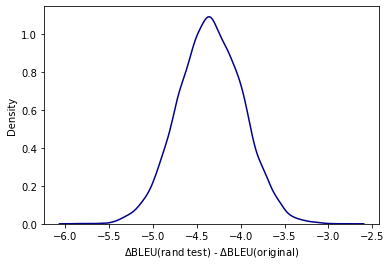

Single Swaps
Number of examples = 1997


/Users/dallas/opt/anaconda3/envs/power/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


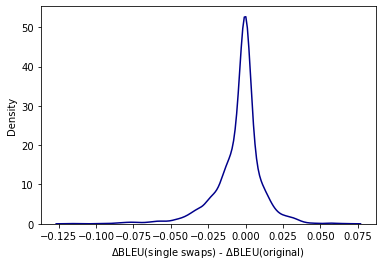

Fit a laplace
Fraction of zeros = 0.1927891837756635
Laplace Fit: (-0.0022916479986676563, 0.011932186794530624)


/Users/dallas/opt/anaconda3/envs/power/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


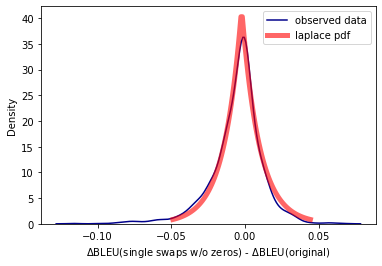

Check correlation


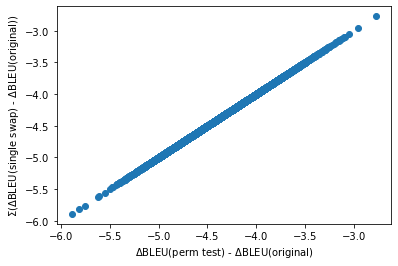

LinregressResult(slope=1.000368114913427, intercept=0.0009746417713882849, rvalue=0.9999999778740764, pvalue=0.0, stderr=2.104597182309402e-06)


In [9]:
perm_file = os.path.join('..', 'data', 'mt', 'wmt19.en-de', 'model18-19-perm10k.npz')
ss_file = os.path.join('..', 'data', 'mt', 'wmt19.en-de', 'model18-19-single-example-swap.npz')
model1 = 'tf19'
model2 = 'tf18'
compare_models(perm_file, ss_file, model1, model2, output_dir, plot=True)

## TF18 vs. TF16 on WMT18 test set

Number of examples = 2998
tf18 bleu score = 44.2306298739456
tf16 bleu score = 40.06859659354174
$\Delta$BLEU(original) i.e. tf18 - tf16 = 4.162033280403861
Randomization Test
Number of trials in the randomization test = 10000
Average$\Delta$BLEU(rand test) = -0.008340064889947115; stdev = 0.397776300227
97.5 percentile of randomization deltas 0.7713604992224166


/Users/dallas/opt/anaconda3/envs/power/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


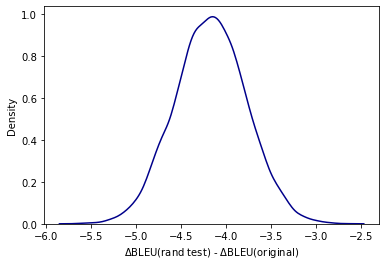

Single Swaps
Number of examples = 2998


/Users/dallas/opt/anaconda3/envs/power/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


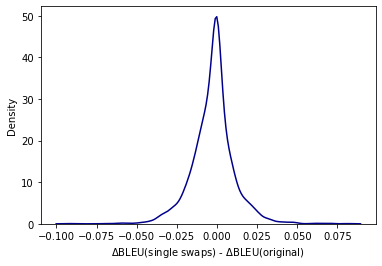

Fit a laplace
Fraction of zeros = 0.09306204136090727
Laplace Fit: (-0.0021889012156606213, 0.009877433535488785)


/Users/dallas/opt/anaconda3/envs/power/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


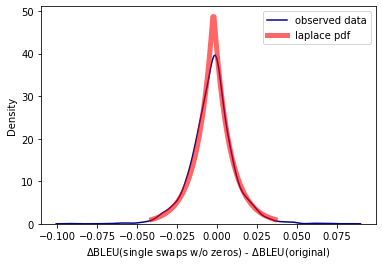

Check correlation


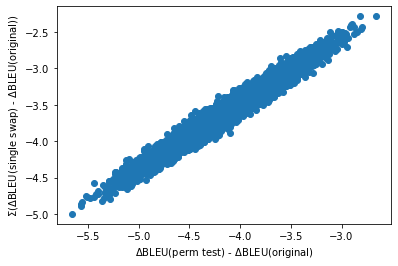

LinregressResult(slope=0.8925576089494947, intercept=0.0887760845144534, rvalue=0.9776787589867929, pvalue=0.0, stderr=0.0019183177864565857)


In [10]:
perm_file = os.path.join('..', 'data', 'mt', 'wmt18.en-de', 'model16-18-perm10k.npz')
ss_file = os.path.join('..', 'data', 'mt', 'wmt18.en-de', 'model16-18-single_example_swap.npz')
model1 = 'tf18'
model2 = 'tf16'
compare_models(perm_file, ss_file, model1, model2, output_dir, plot=True)